First step is to import the dataset into python (or create one, in jupyter notebook):

In [36]:
# Import all the necessary libraries for our project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from prettytable import PrettyTable
import statsmodels.api as sm

# Read the csv file
dataset_ghg = pd.read_csv('Documents/Agreena_Case/CO2_FERT_NEW.csv', sep=';')
print(dataset_ghg.head())

   Year  CO2_Lime  CO2_Urea
0  1990        67       115
1  1991        31        48
2  1992        29        45
3  1993        30        61
4  1994        54        55


Perform feature engineering and convert vaues + check for missing values:

In [37]:
# Check for missing values
print(dataset_ghg.isna().any())

# Convert 'Year' and 'emissions' columns to numeric if needed
dataset_ghg['Year'] = pd.to_numeric( dataset_ghg['Year'])
dataset_ghg['CO2_Lime'] = pd.to_numeric(dataset_ghg['CO2_Lime'])
dataset_ghg['CO2_Urea'] = pd.to_numeric(dataset_ghg['CO2_Urea'])

# Set the 'Year' column as index
dataset_ghg = dataset_ghg.sort_values(by='Year')

Year        False
CO2_Lime    False
CO2_Urea    False
dtype: bool


Now, we will explore the dataframe and print out some basic descriptive statistics, and plot the actual data:

count    32.000000
mean     52.593750
std      20.373701
min      23.000000
25%      33.250000
50%      52.000000
75%      68.000000
max      88.000000
Name: CO2_Lime, dtype: float64
count     32.000000
mean      57.187500
std       17.041576
min       40.000000
25%       46.750000
50%       52.500000
75%       61.000000
max      115.000000
Name: CO2_Urea, dtype: float64


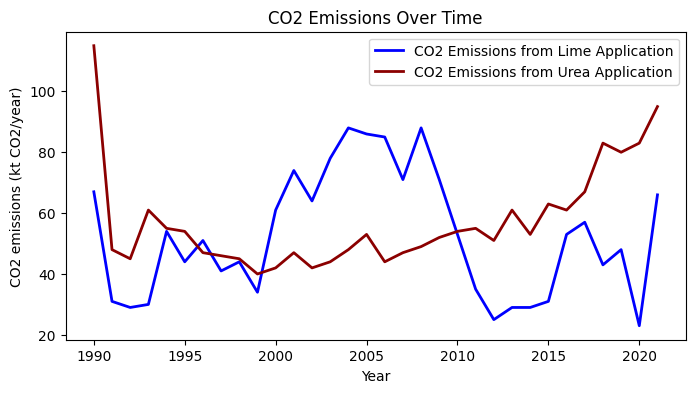

In [38]:
# Print or display the descriptive statistics
lime_descriptive_stats = dataset_ghg['CO2_Lime'].describe()
print(lime_descriptive_stats)
urea_descriptive_stats = dataset_ghg['CO2_Urea'].describe()
print(urea_descriptive_stats)

# Plot Time Series
plt.figure(figsize=(8, 4))

# Plotting N2O_Emissions_From_Animal_Fertilizer
plt.plot(dataset_ghg['Year'], dataset_ghg['CO2_Lime'], label='CO2 Emissions from Lime Application', color= 'blue', linewidth= 2)

# Plotting N2O_Emissions_From_Sewage_Fertilizer
plt.plot(dataset_ghg['Year'], dataset_ghg['CO2_Urea'], label='CO2 Emissions from Urea Application', color= 'darkred', linewidth= 2)

# Adding labels and title
plt.title('CO2 Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (kt CO2/year)')
plt.legend()
plt.grid(False)
plt.show()



In order to see what forecast model we can fit on our time series, we will perform decomposition to check for trend, seasonality and noise:

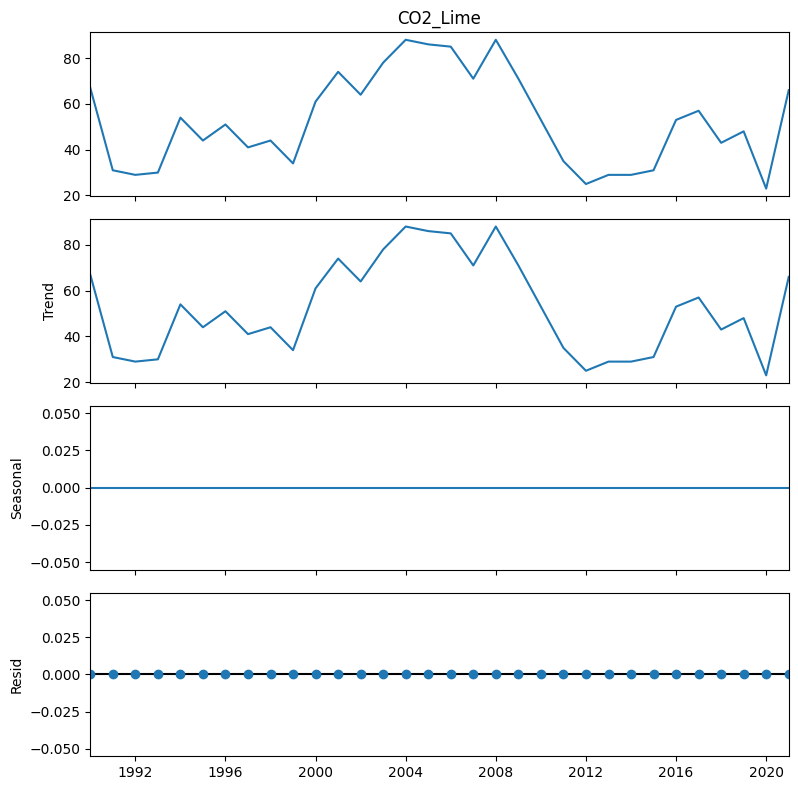

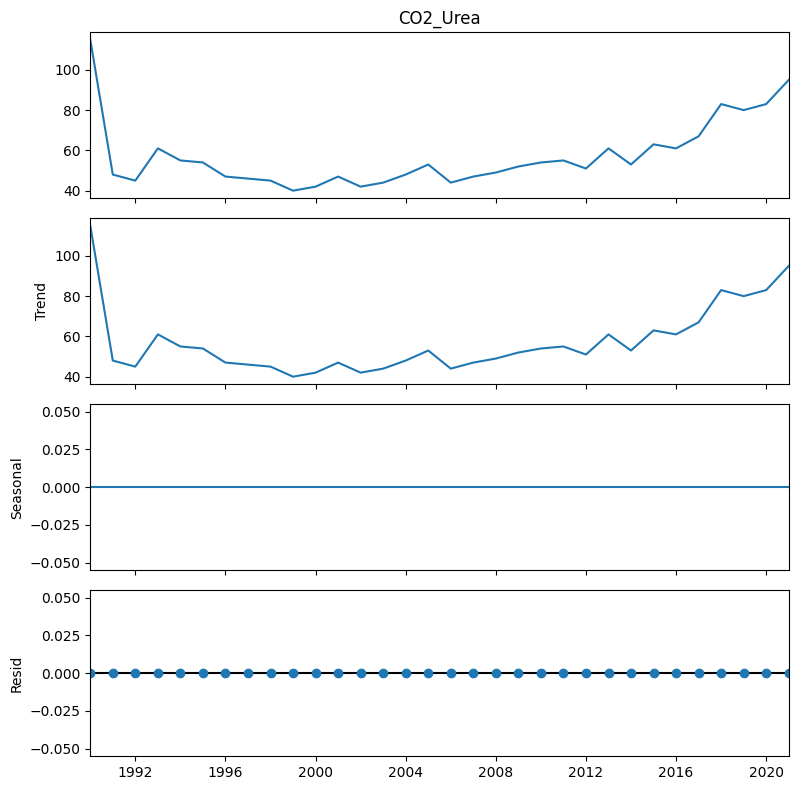

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose 

# Convert the 'Year' column to a datetime index
dataset_ghg['Year'] = pd.to_datetime(dataset_ghg['Year'], format='%Y')
dataset_ghg.set_index('Year', inplace=True)

# Sort the DataFrame by 'Year'
dataset_ghg = dataset_ghg.sort_values(by='Year')

# Decompose the data frame to get the trend, seasonality and noise - Lime
decompose_result = seasonal_decompose(dataset_ghg['CO2_Lime'],model='add', period= None)
decompose_result.plot()
plt.show()

# Decompose the data frame to get the trend, seasonality and noise - Urea
decompose_result = seasonal_decompose(dataset_ghg['CO2_Urea'],model='add', period=None)
decompose_result.plot()
plt.show()

As we can see from the plots above, there is no seasonality in our time series, and the trend is unclear, thus, our model should not take into account seasonality

The nex step in chosing our forecast, is to determine wether the time series is stationary or not, using the Augumented Dickey-Fuller test:

In [40]:
# Check for stastionary using ADF
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for CO2_Lime - STATIONARY
result_lime = adfuller(dataset_ghg['CO2_Lime'])
print('ADF Statistic for CO2_Lime:', result_lime[0])
print('p-value for CO2_Lime:', result_lime[1])
print('Critical Values for CO2_Lime:', result_lime[4])

# Perform ADF test for CO2_Urea - STATIONARY
result_urea = adfuller(dataset_ghg['CO2_Urea'])
print('\nADF Statistic for CO2_Urea:', result_urea[0])
print('p-value for CO2_Urea:', result_urea[1])
print('Critical Values for CO2_Urea:', result_urea[4])

ADF Statistic for CO2_Lime: -2.3866989837116948
p-value for CO2_Lime: 0.1455257676904897
Critical Values for CO2_Lime: {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}

ADF Statistic for CO2_Urea: 2.3067256477677405
p-value for CO2_Urea: 0.9989594154745927
Critical Values for CO2_Urea: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}


From the ADF tests, we can observe that none of the critical values are higher than the Statistics or p-value, thus we can conclude that the null hypothesis is valid and the time series is NON-STATIONARY. This means that we should chose a model to handle a short, non-stationary time-series, without seasonality. This is why we opted for the simple ARIMA model.

To determine which order (p,d,q) we should use for our ARIMA mode, we firs have to prepare the data and perform a few estra steps:

In [41]:

# Prepare data for ARIMA for CO2_Urea
# Sort the DataFrame by 'Year'
dataset_ghg = dataset_ghg.sort_values(by='Year')

# Check if 'Year' is already the index
if 'Year' in dataset_ghg.columns:
    dataset_ghg.set_index('Year', inplace=True)
    
# Prepare data for ARIMA for CO2_Lime
X_lime = dataset_ghg['CO2_Lime']
dates_lime = pd.date_range(start=str(dataset_ghg.index.min()), periods=len(dataset_ghg), freq='Y')
time_series_lime = pd.Series(X_lime.values, index=dates_lime)

# Prepare data for ARIMA for CO2_Urea
X_urea = dataset_ghg['CO2_Urea']
dates_urea = pd.date_range(start=str(dataset_ghg.index.min()), periods=len(dataset_ghg), freq='Y')
time_series_urea = pd.Series(X_urea.values, index=dates_urea)


Now, we can plot the ACF and PACF, to identify the p and q values for our ARIMA model order:

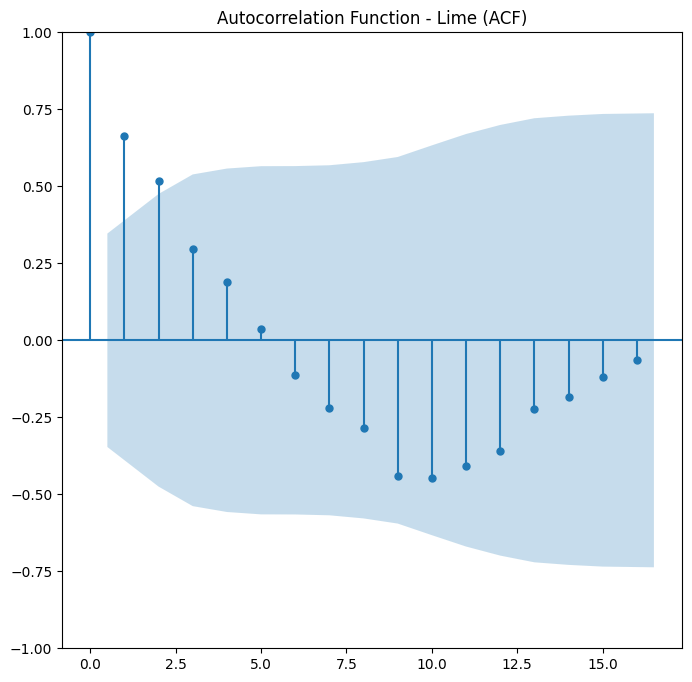

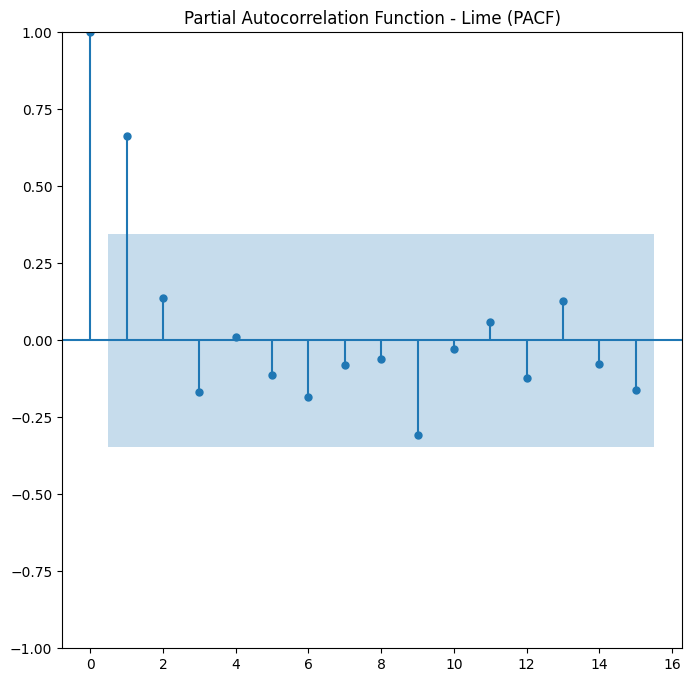

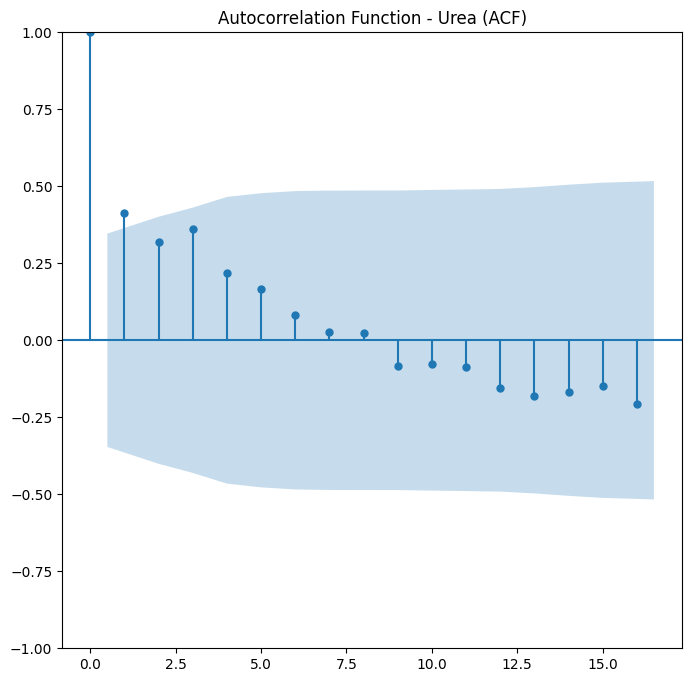

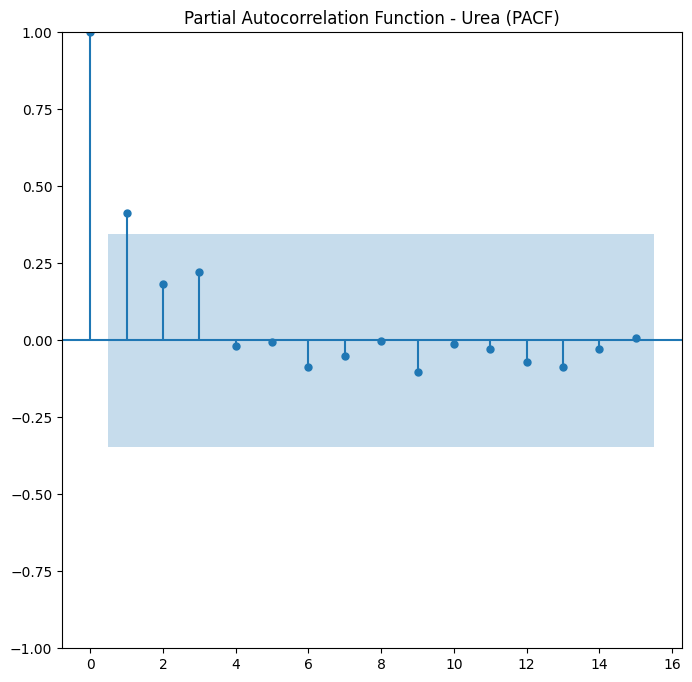

In [42]:
# Choose the order (p, d, q) based on PACF and ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF - Lime
plot_acf(dataset_ghg['CO2_Lime'])
plt.title('Autocorrelation Function - Lime (ACF)')
plt.show()

# Plot PACF - Lime
plot_pacf(dataset_ghg['CO2_Lime'], lags=min(15, len(dataset_ghg['CO2_Lime']) - 1))
plt.title('Partial Autocorrelation Function - Lime (PACF)')
plt.show()

# Plot ACF - Urea
plot_acf(dataset_ghg['CO2_Urea'])
plt.title('Autocorrelation Function - Urea (ACF)')
plt.show()

# Plot PACF - Urea
plot_pacf(dataset_ghg['CO2_Urea'], lags=min(15, len(dataset_ghg['CO2_Urea']) - 1))
plt.title('Partial Autocorrelation Function - Urea (PACF)')
plt.show()

As we can observe, for the Lime plots, for the ACF plot: the first 2 lags are out of the limit significantly, thus we can set the q value to 2. The PACF plot has as well the first two lags out of the limit, so we se the p value to 2.

For the Urea plots, the ACF plot has the first lag out of the limit, while the second lag is still out of the limit only by a little, so we can chose the q value 1. Similary, the PACF plot has the first lag out of the limit and the second one only slightly, thus we chose the p value 1.

After chosing the p and q value, we need to determine the order of differencing, to stabilize out time series and make it stationary. This can be achieved by differencing our time series:

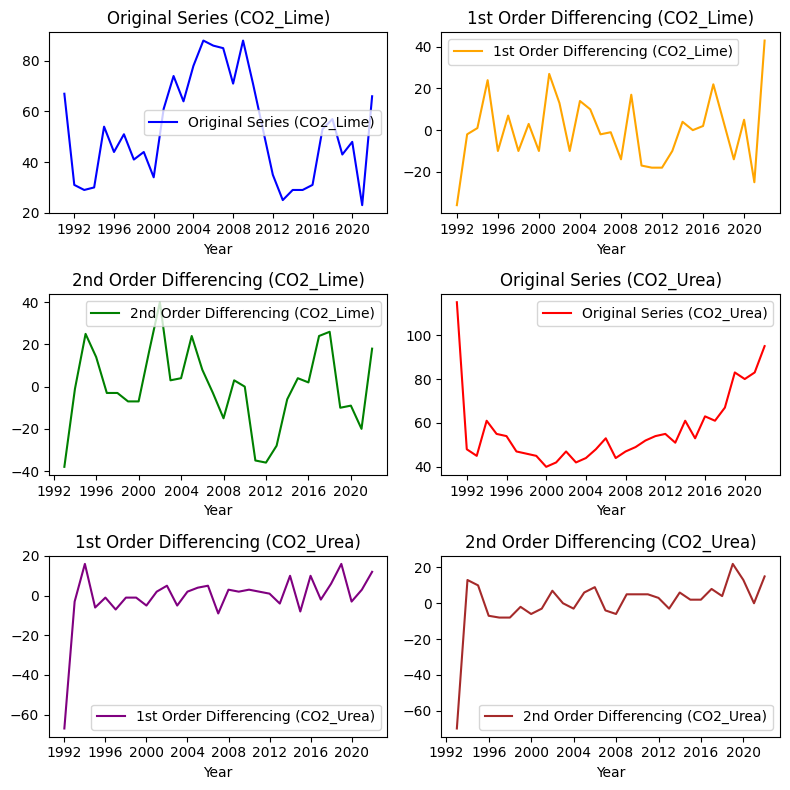

In [43]:
# Perform differencing on CO2_Lime
diff_order_lime = 1  
X_lime_diff = X_lime.diff(diff_order_lime).dropna()

# Perform differencing on CO2_Urea
diff_order_urea = 1  
X_urea_diff = X_urea.diff(diff_order_urea).dropna()

# Perform 2nd order differencing on CO2_Lime
diff_order_lime_2nd = 2
X_lime_diff_2nd = X_lime.diff(diff_order_lime_2nd).dropna()

# Perform 2nd order differencing on CO2_Urea
diff_order_urea_2nd = 2  
X_urea_diff_2nd = X_urea.diff(diff_order_urea_2nd).dropna()

# Plot the original, 1st order differencing, and 2nd order differencing series
plt.rcParams.update({'figure.figsize':(8, 8), 'figure.dpi':100})

# Original Series for CO2_Lime
plt.subplot(3, 2, 1)
plt.plot(time_series_lime.index, time_series_lime.values, label='Original Series (CO2_Lime)', color='blue')
plt.title('Original Series (CO2_Lime)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

# 1st Differencing for CO2_Lime
plt.subplot(3, 2, 2)
plt.plot(time_series_lime.index[1:], X_lime_diff.values, label='1st Order Differencing (CO2_Lime)', color='orange')
plt.title('1st Order Differencing (CO2_Lime)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

# 2nd Differencing for CO2_Lime
plt.subplot(3, 2, 3)
plt.plot(time_series_lime.index[2:], X_lime_diff_2nd.values, label='2nd Order Differencing (CO2_Lime)', color='green')
plt.title('2nd Order Differencing (CO2_Lime)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

# Original Series for CO2_Urea
plt.subplot(3, 2, 4)
plt.plot(time_series_urea.index, time_series_urea.values, label='Original Series (CO2_Urea)', color='red')
plt.title('Original Series (CO2_Urea)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

# 1st Differencing for CO2_Urea
plt.subplot(3, 2, 5)
plt.plot(time_series_urea.index[1:], X_urea_diff.values, label='1st Order Differencing (CO2_Urea)', color='purple')
plt.title('1st Order Differencing (CO2_Urea)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

# 2nd Differencing for CO2_Urea
plt.subplot(3, 2, 6)
plt.plot(time_series_urea.index[2:], X_urea_diff_2nd.values, label='2nd Order Differencing (CO2_Urea)', color='brown')
plt.title('2nd Order Differencing (CO2_Urea)')
plt.grid(False)
plt.xlabel('Year')
plt.legend()

plt.tight_layout()
plt.show()

From the above plots, we can observe that the 2nd order of differencing produced the plots with the least amount of noise and the time series have become stationary. Thus, we chose the value of d = 2.

Tyhe next step is to fit the ARIMA model with the defined p,d,q order and check the summary:

In [44]:
# Fit an ARIMA model for CO2_Lime
model_lime = ARIMA(time_series_lime, order=(2, 2, 2))
results_lime = model_lime.fit()
print(results_lime.summary())

# Fit an ARIMA model for CO2_Urea
model_urea = ARIMA(time_series_urea, order=(1, 2, 1))
results_urea = model_urea.fit()
print(results_urea.summary())

# Remove the first two residuals (d=2) and refit the model
# Extract the first two residuals
residuals_lime = results_lime.resid[:2]
residuals_urea = results_urea.resid[:2]

# Re-estimate the model without the first two residuals for CO2_Lime
model_lime_excluded = ARIMA(time_series_lime.iloc[2:], order=(2, 2, 2))
results_lime_excluded = model_lime_excluded.fit()

# Re-estimate the model without the first two residuals for CO2_Urea
model_urea_excluded = ARIMA(time_series_urea.iloc[2:], order=(1, 2, 1))
results_urea_excluded = model_urea_excluded.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -127.624
Date:                Tue, 19 Dec 2023   AIC                            265.247
Time:                        09:52:31   BIC                            272.253
Sample:                    12-31-1990   HQIC                           267.488
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7527      0.887     -0.849      0.396      -2.491       0.986
ar.L2          0.0691      0.464      0.149      0.882      -0.841       0.979
ma.L1         -0.4197    127.402     -0.003      0.9

Now, we must check our time series for residuals and their mean, in order to see if our model will fit correctly:

Mean of Residuals: 3.838326901475246


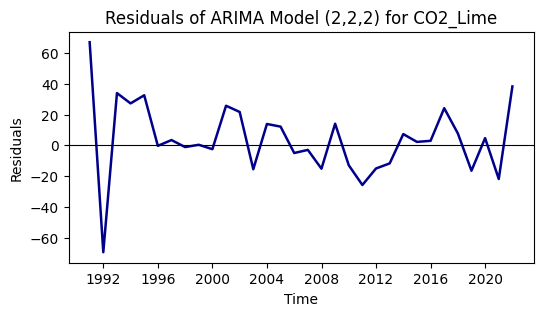

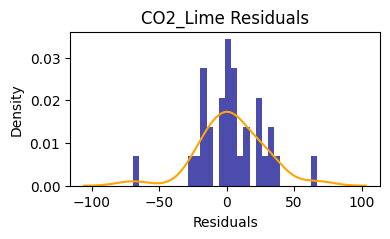

Mean of Residuals: 6.868951405076047


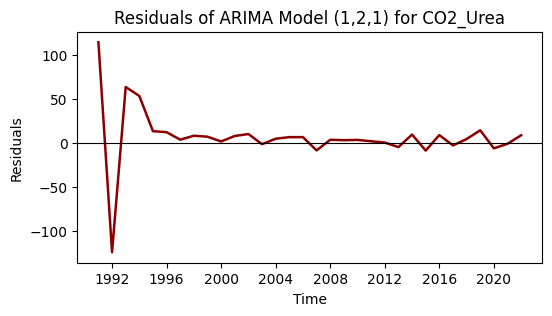

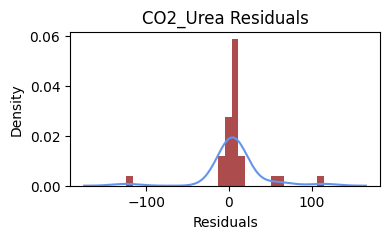

In [45]:
# Check for Residuals
import numpy as np
# Get the residuals from the ARIMA model - LIME
residuals_lime = results_lime.resid
# Check the mean of residuals- LIME
mean_residuals_lime = np.mean(residuals_lime)
print(f"Mean of Residuals: {mean_residuals_lime}")

# Plot the residuals - LIME
plt.figure(figsize=(6, 3))
plt.plot(residuals_lime, color = 'darkblue', linewidth=1.8)
plt.axhline(y=0, color='black', linestyle='-', linewidth= 0.8)
plt.title('Residuals of ARIMA Model (2,2,2) for CO2_Lime')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# histogram of the residuals - LIME
plt.figure(figsize=(4, 2))
plt.hist(residuals_lime, bins=30, density=True, alpha=0.7, color='darkblue')

# Overlay a KDE plot
sns.kdeplot(residuals_lime, color='orange', label='KDE')
plt.title('CO2_Lime Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Get the residuals from the ARIMA model - UREA
residuals_urea = results_urea.resid
# Check the mean of residuals- UREA
mean_residuals_urea = np.mean(residuals_urea)
print(f"Mean of Residuals: {mean_residuals_urea}")

# Plot the residuals - UREA
plt.figure(figsize=(6, 3))
plt.plot(residuals_urea, color = 'darkred', linewidth=1.8)
plt.axhline(y=0, color='black', linestyle='-', linewidth= 0.8)
plt.title('Residuals of ARIMA Model (1,2,1) for CO2_Urea')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# histogram of the residuals - UREA
plt.figure(figsize=(4, 2))
plt.hist(residuals_urea, bins=30, density=True, alpha=0.7, color='darkred')
# Overlay a KDE plot
sns.kdeplot(residuals_urea, color='cornflowerblue', label='KDE')
plt.title('CO2_Urea Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()




As we can see, the residuals are nromally distributed and have a mean close to 0. (If we apply the correction to the forecast).

The next step to validate our model is to perform the Ljung-Box test for the residual white noise correlation:

In [46]:
# Perform Ljung-Box Test on residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
print('LB Test Results for LIME')
print(sm.stats.acorr_ljungbox(results_lime.resid, lags=[15], return_df=True))
print('LB Test Results for UREA')
print(sm.stats.acorr_ljungbox(results_urea.resid, lags=[15], return_df=True))

LB Test Results for LIME
     lb_stat  lb_pvalue
15  7.479582   0.942951
LB Test Results for UREA
      lb_stat  lb_pvalue
15  10.763833   0.769149


From this test, we can see that the p-values are over 0.05, thus, we can accept the null hypopthesis and conclude that the residuals are independently distributed and are not distinguishable form a white noise series = > MODEL IS ADEQUATE!

Now, to see how our model fits the actual data, we have plotted the time series to check for fitting:

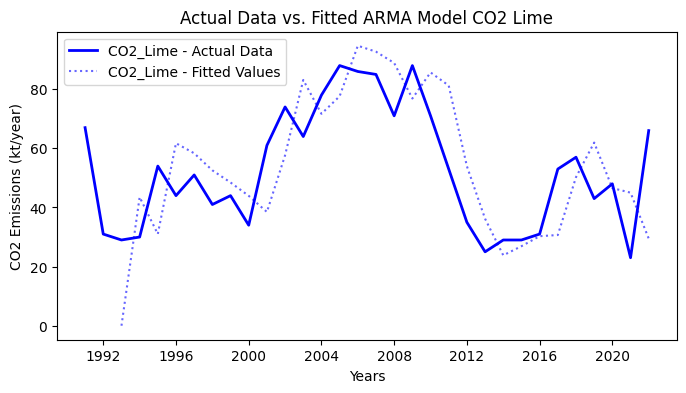

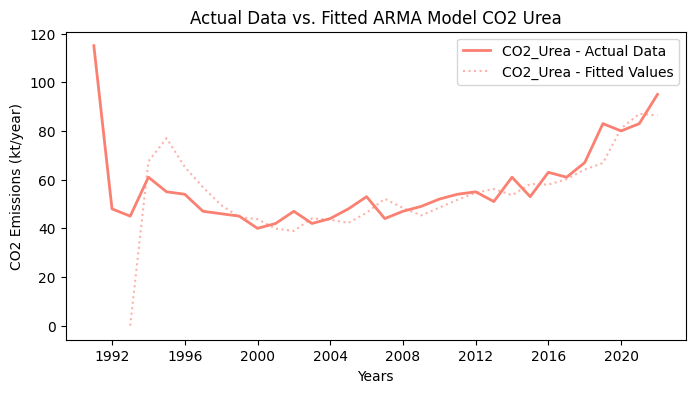

In [47]:
# Plot actual data vs ARIMA fit
plt.figure(figsize=(8, 4))
plt.plot(time_series_lime.index, time_series_lime.values, label='CO2_Lime - Actual Data', color='blue', linewidth=2)

plt.plot(results_lime_excluded.fittedvalues.index, results_lime_excluded.fittedvalues.values, label='CO2_Lime - Fitted Values', color='blue',
         linestyle='dotted', alpha=0.6)
plt.xlabel('Years')
plt.ylabel('CO2 Emissions (kt/year)')
plt.title('Actual Data vs. Fitted ARMA Model CO2 Lime')
plt.legend()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(time_series_urea.index, time_series_urea.values, label='CO2_Urea - Actual Data', color='salmon', linewidth=2)
plt.plot(results_urea_excluded.fittedvalues.index, results_urea_excluded.fittedvalues.values, label='CO2_Urea - Fitted Values', color='salmon',
         linestyle='dotted', alpha=0.6)
plt.xlabel('Years')
plt.ylabel('CO2 Emissions (kt/year)')
plt.title('Actual Data vs. Fitted ARMA Model CO2 Urea')
plt.legend()
plt.show()

Now that we see that our model fits satisfactory to the actual data, we can proceed to the forecasting and plotting step: